# Heartbeat LSTM Autoencoder

Modified from the [Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python](https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/), this project improves it by allowing batched training. 

It improves the training time drastically when the data size is large. 


In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data

# SciKit
from sklearn.model_selection import train_test_split

# Python
import pandas as pd
import numpy as np
import time
from arff2pandas import a2p

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Set random set for reproducible results:

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


Declaring machine learning parameters:

In [3]:
# ML Parameters
lr = 1e-3
epoch = 100
batch_size = 512

# Data Parameters
data_seq_len = 140
data_n_features = 1
data_embedding_dim = 64


Data Cleaning:

In [4]:
# Open the files using A2P
with open('ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
    test = a2p.load(f)

# Concatenate data in the training and testing files
df = train.append(test)
df = df.sample(frac=1.0)
df.shape


(5000, 141)

In [5]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


In [6]:
# Rename the last column as "target"
new_columns = list(df.columns)   # copy a list of columns
new_columns[-1] = 'target'       # change the last item to "target"
df.columns = new_columns         # assign to data columns

# Separate normal heartbeat 
CLASS_NORMAL = 1
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
print("Normal:", normal_df.shape)

# Separate abnormal heartbeat
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
print("Anomaly:", anomaly_df.shape)


Normal: (2919, 140)
Anomaly: (2081, 140)


Create 3 Datasets (Training, Validation, Testing) :

In [7]:
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=RANDOM_SEED)


Declare Dataset Class:

In [8]:
class HeartbeatDataset(data.Dataset):

    def __init__(self, df):
        self.sequences = df.astype(np.float32).to_numpy()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        out = self.sequences[idx]
        out = out.reshape((-1, 1))   # change from (seq_len,) to (seq_len, n_features) (i.e., (140,1))
        return out


Instantiate Dataset Class Objects:

In [9]:
# Dataset Objects
train_dataset = HeartbeatDataset(train_df)
val_dataset = HeartbeatDataset(val_df)
test_dataset = HeartbeatDataset(test_df)
test_anomaly_dataset = HeartbeatDataset(anomaly_df)

# PyTorch DataLoader Objects
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_anomaly_loader = data.DataLoader(test_anomaly_dataset, batch_size=batch_size, shuffle=False, drop_last=False)


Our Machine Learning model is a LSTM Encoder and a LSTM Decoder (i.e., autoencoder):

In [10]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, seq_len, n_features, embedding_dim):
        super(LSTMEncoder, self).__init__()
        
        # Parameters
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2*embedding_dim
        
        # Neural Network Layers
        self.lstm1 = nn.LSTM(self.n_features, self.hidden_dim, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_dim, self.embedding_dim, num_layers=1, batch_first=True)
    
    def forward(self, i): 
        i, _ = self.lstm1(i)               # from (batch, seq_len, n_features) to (batch, seq_len, hidden_dim)
        i, (hidden_n, _) = self.lstm2(i)   # from (batch, seq_len, hidden_dim) to (batch, seq_len, embedding_dim)
        return hidden_n                    # hidden_n shape: (num_layers*num_directions, batch, embedding_dim)


class LSTMDecoder(nn.Module):

    def __init__(self, seq_len, embedding_dim, n_features=1):
        super(LSTMDecoder, self).__init__()

        # Parameters
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2*embedding_dim
        self.n_features = n_features
        
        # Neural Network Layers
        self.lstm1 = nn.LSTM(self.embedding_dim, self.embedding_dim, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(self.embedding_dim, self.hidden_dim, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, i):
        # Do padding
        i = i.repeat(self.seq_len, 1, 1)                       # repeat (1, embedding_dim) to (seq_len, embedding_dim)
        i = i.reshape((-1, self.seq_len, self.embedding_dim))  # reshape to (batch, seq_len, embedding_dim)
        
        # Traverse neural layers
        i, _ = self.lstm1(i)      # from (batch, seq_len, embedding_dim) to (batch, seq_len, embedding_dim)
        i, _ = self.lstm2(i)      # from (batch, seq_len, embedding_dim) to (batch, seq_len, hidden_dim)
        i = self.output_layer(i)  # from (batch, seq_len, hidden_dim) to (batch, seq_len, n_features)
        
        return i


class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = LSTMDecoder(seq_len, embedding_dim, n_features).to(device)
        
    def forward(self, i):
        i = self.encoder(i)
        i = self.decoder(i)
        return i


Define and build machine learning model:

In [11]:
# Define model1 for E1
model = LSTMAutoencoder(data_seq_len, data_n_features, data_embedding_dim)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


Training and Validation Testing Function:

In [12]:
def training(model, optimizer, trainset_iterator, validationset_iterator, epoch):
    train_losses, test_losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)

    for epoch in range(epoch):
        
        print("Epoch %d training started ..." % epoch)
        start_time = time.time()
        
        # Enter Train Mode
        model.train()     
        train_loss = 0
        for ii in trainset_iterator:
            ii = ii.to(device)              # move to GPU if necessary
            optimizer.zero_grad()           # generate prediction
            preds = model(ii)               # generate prediction
            loss = criterion(preds, ii)     # calculate loss
            loss.backward()                 # back propagation of gradients and update weights
            optimizer.step()                # update optimizer
            train_loss += loss.item()       # record training losses

        # Enter Validation Mode
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for ii in validationset_iterator:
                ii = ii.to(device)          # move to GPU if necessary
                preds = model(ii)           # generate prediction
                loss = criterion(preds, ii) # calculate loss
                test_loss += loss           # record validation testing losses
        
        end_time = time.time()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print("Epoch %d completed - train_loss: %f , test_loss: %f" % (epoch, train_loss, test_loss))
        print("Epoch %d training time: %f" %(epoch, (end_time - start_time)))
    
    return train_losses, test_losses


Predict Function:

In [13]:
def predict(model, dataset_iterator):
    preds, losses = np.array([]), np.array([])
    criterion = nn.L1Loss(reduction='none').to(device)
    
    # Enter Validation Mode
    model = model.eval()
    with torch.no_grad():
        for ii in dataset_iterator:
            
            # move to GPU if necessary
            ii = ii.to(device)
            
            # generate prediction
            pred = model(ii)
            
            # calculate loss
            loss = criterion(pred, ii)
            
            # record predictions
            preds = np.append(preds, pred.cpu().numpy())
            
            # record mean loss of each sample
            loss = loss.reshape((-1, data_seq_len)).numpy()  # from (batch, seq_len, n_feature) to (batch, seq_len)
            losses = np.append(losses, [np.sum(i) for i in loss])  # sum of all seq_len losses into one loss
    
    preds = preds.reshape((-1, data_seq_len))  # reshape to (batch, seq_len)
    return preds, losses


Training Execution:

In [14]:
# Training:
train_losses, test_losses = training(model, optimizer, train_loader, val_loader, epoch)

# Saving trained models
torch.save(model, './heartbeat_model.pth')


Epoch 0 training started ...
Epoch 0 completed - train_loss: 231733.667969 , test_loss: 27437.972656
Epoch 0 training time: 27.707587
Epoch 1 training started ...
Epoch 1 completed - train_loss: 231246.234375 , test_loss: 27346.759766
Epoch 1 training time: 27.546430
Epoch 2 training started ...
Epoch 2 completed - train_loss: 229804.941406 , test_loss: 26872.294922
Epoch 2 training time: 27.456909
Epoch 3 training started ...
Epoch 3 completed - train_loss: 219847.679688 , test_loss: 25658.199219
Epoch 3 training time: 27.550148
Epoch 4 training started ...
Epoch 4 completed - train_loss: 233033.253906 , test_loss: 25855.962891
Epoch 4 training time: 33.207605
Epoch 5 training started ...
Epoch 5 completed - train_loss: 217803.707031 , test_loss: 25864.339844
Epoch 5 training time: 31.107932
Epoch 6 training started ...
Epoch 6 completed - train_loss: 217430.832031 , test_loss: 25970.683594
Epoch 6 training time: 27.805812
Epoch 7 training started ...
Epoch 7 completed - train_loss: 2

Epoch 60 completed - train_loss: 137306.720703 , test_loss: 16160.382812
Epoch 60 training time: 27.039991
Epoch 61 training started ...
Epoch 61 completed - train_loss: 137489.875000 , test_loss: 15996.889648
Epoch 61 training time: 27.232455
Epoch 62 training started ...
Epoch 62 completed - train_loss: 137090.167969 , test_loss: 15906.000000
Epoch 62 training time: 27.024246
Epoch 63 training started ...
Epoch 63 completed - train_loss: 136491.636719 , test_loss: 15935.166992
Epoch 63 training time: 27.066330
Epoch 64 training started ...
Epoch 64 completed - train_loss: 136147.923828 , test_loss: 15913.698242
Epoch 64 training time: 27.078482
Epoch 65 training started ...
Epoch 65 completed - train_loss: 135942.445312 , test_loss: 15876.890625
Epoch 65 training time: 29.382327
Epoch 66 training started ...
Epoch 66 completed - train_loss: 135847.123047 , test_loss: 15864.503906
Epoch 66 training time: 28.312318
Epoch 67 training started ...
Epoch 67 completed - train_loss: 136191.9

Plot Losses:

Text(0.5, 1.0, 'Model1: Loss vs. No. of epochs')

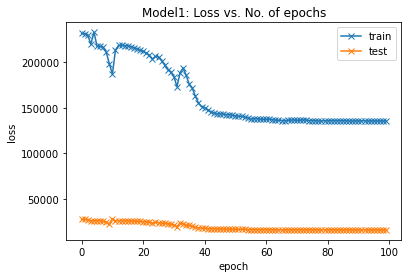

In [15]:
plt.figure()
plt.plot(train_losses, '-x')
plt.plot(test_losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.title('Model1: Loss vs. No. of epochs')


Plot Regenerated Signal and Frequencies:

/Users/chriz/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Regenerated Signal for Normal Data')

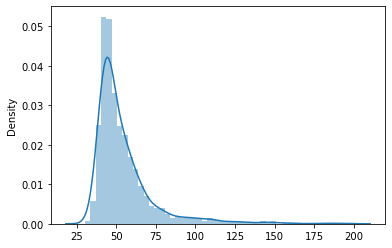

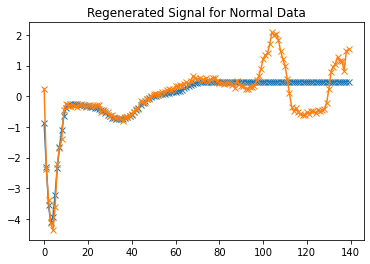

In [22]:
regenerated_normal, losses_normal = predict(model, train_loader)
sns.distplot(losses_normal, bins=50, kde=True)
plt.figure()
plt.plot(regenerated_normal[0], '-x')
plt.plot(train_dataset[0], '-x')
plt.title('Regenerated Signal for Normal Data')


Plot Regenerated Signal and Frequencies:

/Users/chriz/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Regenerated Signal for Anomaly Data')

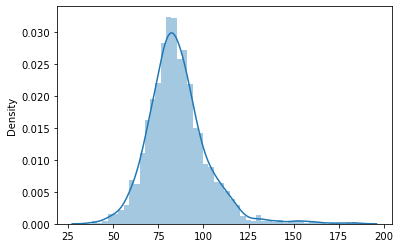

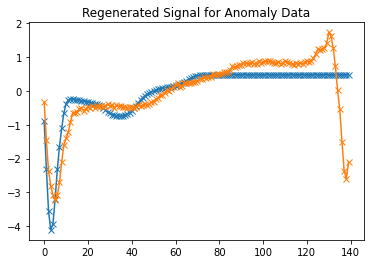

In [23]:
regenerated_anomaly, losses_anomaly = predict(model, test_anomaly_loader)
sns.distplot(losses_anomaly, bins=50, kde=True)
plt.figure()
plt.plot(regenerated_anomaly[0], '-x')
plt.plot(test_anomaly_dataset[0], '-x')
plt.title('Regenerated Signal for Anomaly Data')


Configure threshold to determine inliers and outliers:

/Users/chriz/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Normal predictions for model: 78


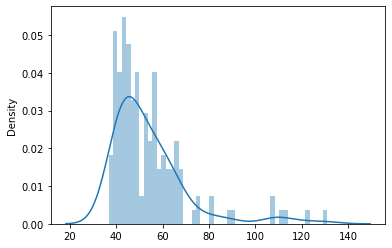

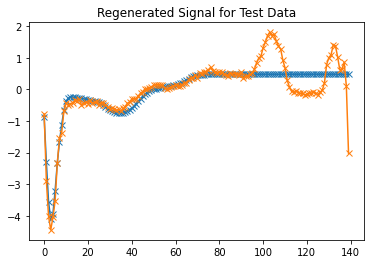

In [25]:
THRESHOLD = 50

regenerated_test, losses_test = predict(model, test_loader)
sns.distplot(losses_test, bins=50, kde=True)
plt.figure()
plt.plot(regenerated_test[0], '-x')
plt.plot(test_dataset[0], '-x')
plt.title('Regenerated Signal for Test Data')

print(f'Normal predictions for model: {sum(l <= THRESHOLD for l in pred_losses)}')
